In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import pytorch
import torch
from torch import nn

# progress bar
from tqdm.auto import tqdm

# Import torchVision
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets

torch.__version__, torchvision.__version__

('2.1.0+cu121', '0.16.0+cu121')

In [115]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Getting Dataset

In [116]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor(),
    target_transform=None # you can transform labels as well
)

In [117]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [118]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

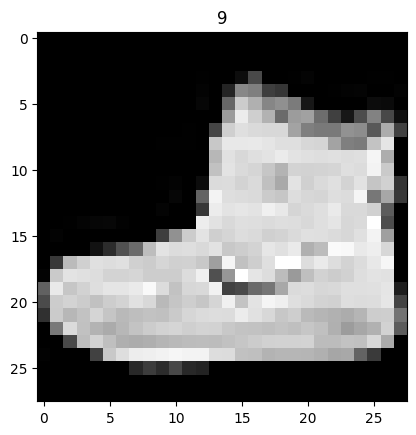

In [119]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

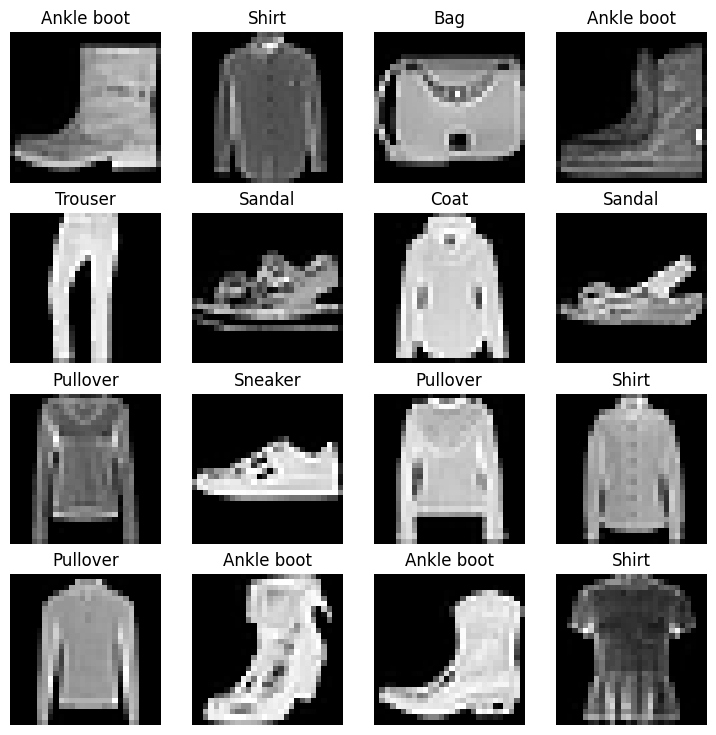

In [120]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
row, col = 4, 4
for i in range(1, row*col+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

In [121]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [122]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(torch.Size([1, 28, 28]), torch.Size([]))

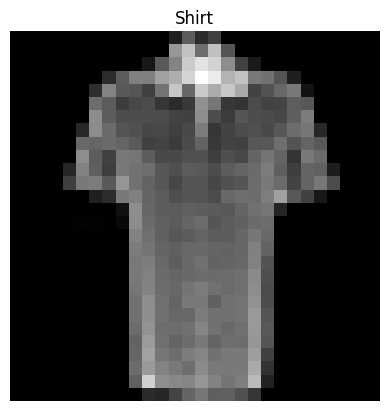

In [123]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_feature_batch), size=[1]).item()
img, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
img.shape, label.shape

In [124]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



# Import accuracy metric
from helper_functions import accuracy_fn
# Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


helper_functions.py already exists, skipping download


In [125]:
from timeit import default_timer as timer

def print_train_timer(start: float,
                      end: float,
                      device: torch.device = None) -> float:
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [126]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device)-> dict:
  """Returns a dictonary containning the result of model predicting on data_loader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:

      # send data to target device
      X, y = X.to(device), y.to(device)

      # make prediction
      y_pred = model(X)

      # accumulate the loss and acc value per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      "model_name": model.__class__.__name__, # only works whem model create with class
      "model_loss": loss.item(),
      "model_acc": acc
  }

In [127]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device) -> None:

  ''' Performs training with model trying to learn on data_loader.'''
  train_loss, train_acc = 0, 0

  # put model in training mode
  model.train()

  # loop to go through batches
  for batch, (X,y) in enumerate(data_loader):

    # Send data to GPU
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs raw logits form the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update model's parameters per batch)
    optimizer.step()

  # Device total train loss and acc by len of train_dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')


In [128]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device) -> None:

  """Performs a testing loop step on model going over data_loader."""

  test_loss, test_acc= 0,0

  # put model in eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    for X,y in data_loader:

      # send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. calculate loss and acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred= test_pred.argmax(dim=1)) # logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% \n')

In [129]:
class FashionMNISTModel(nn.Module):

  """ Model archicture that replicates the TinyVGG model from CNN explainer website"""

  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):

    super(FashionMNISTModel, self).__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(p=0.01),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units *2,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units *2,
                  out_channels=hidden_units *2,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(p=0.025),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*2 * (7*7),
                  out_features= hidden_units*4),
        nn.BatchNorm1d(128),
        nn.Linear(in_features=hidden_units*4, # set ?*? to 0 then get error to know what to multiply as layer flattened
                  out_features=output_shape)
    )

  def forward(self, x):

    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape) #we need shape of this out put to get what to multiply after flatten layer '?*?'
    x = self.classifier(x)
    # print(x.shape, x.dtype)

    return x

In [130]:
torch.manual_seed(42)

model = FashionMNISTModel(input_shape=1,
                          hidden_units=32,
                          output_shape=len(class_names)).to(device)
model

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.01, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.025, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, b

In [131]:
 # set up loss function/eval_metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [132]:
# training and testing using function

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start_model = timer()

# Train and test model

epochs = 10
for epoch in tqdm(range(epochs)):

  print(f'Epoch: {epoch}\n----')
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model = timer()
total_train_time = print_train_timer(start=train_time_start_model,
                                     end=train_time_end_model,
                                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 0.36522 | Train acc: 86.90%
Test loss: 0.27413 | Test acc: 90.15% 

Epoch: 1
----
Train loss: 0.25352 | Train acc: 90.97%
Test loss: 0.25238 | Test acc: 91.02% 

Epoch: 2
----
Train loss: 0.22183 | Train acc: 92.06%
Test loss: 0.23614 | Test acc: 91.70% 

Epoch: 3
----
Train loss: 0.20117 | Train acc: 92.74%
Test loss: 0.22380 | Test acc: 91.99% 

Epoch: 4
----
Train loss: 0.17980 | Train acc: 93.41%
Test loss: 0.21616 | Test acc: 92.46% 

Epoch: 5
----
Train loss: 0.16582 | Train acc: 93.96%
Test loss: 0.24095 | Test acc: 91.40% 

Epoch: 6
----
Train loss: 0.15126 | Train acc: 94.49%
Test loss: 0.22423 | Test acc: 92.24% 

Epoch: 7
----
Train loss: 0.14022 | Train acc: 94.94%
Test loss: 0.21942 | Test acc: 92.56% 

Epoch: 8
----
Train loss: 0.13225 | Train acc: 95.17%
Test loss: 0.23761 | Test acc: 92.15% 

Epoch: 9
----
Train loss: 0.11844 | Train acc: 95.67%
Test loss: 0.23557 | Test acc: 92.13% 

Train time on cuda: 140.318 seconds


In [133]:
# lets get result dictonary

model_results = eval_model(model=model,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)
model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.23556596040725708,
 'model_acc': 92.13258785942492}

In [148]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [160]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [161]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

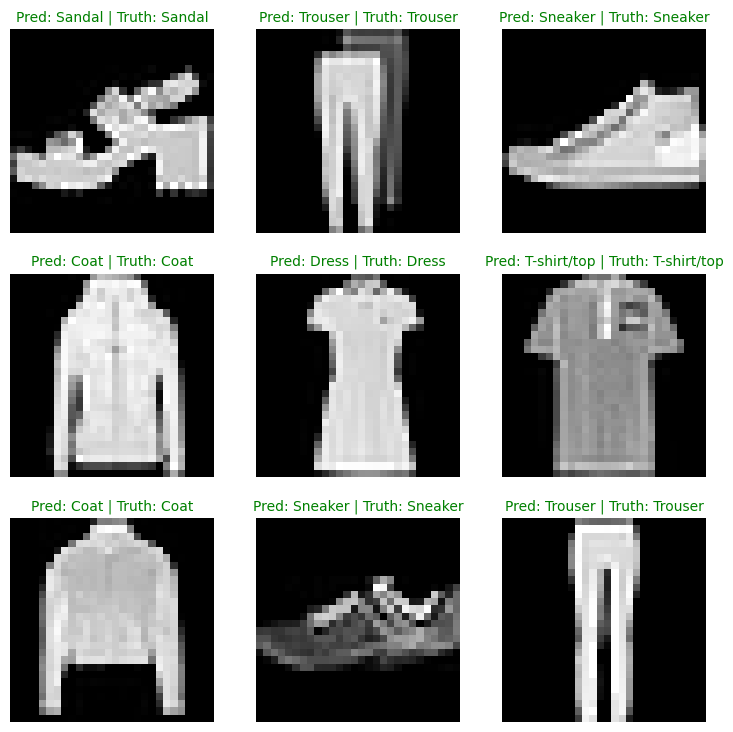

In [162]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [163]:
### Confusion Matrix

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [164]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.3 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [165]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


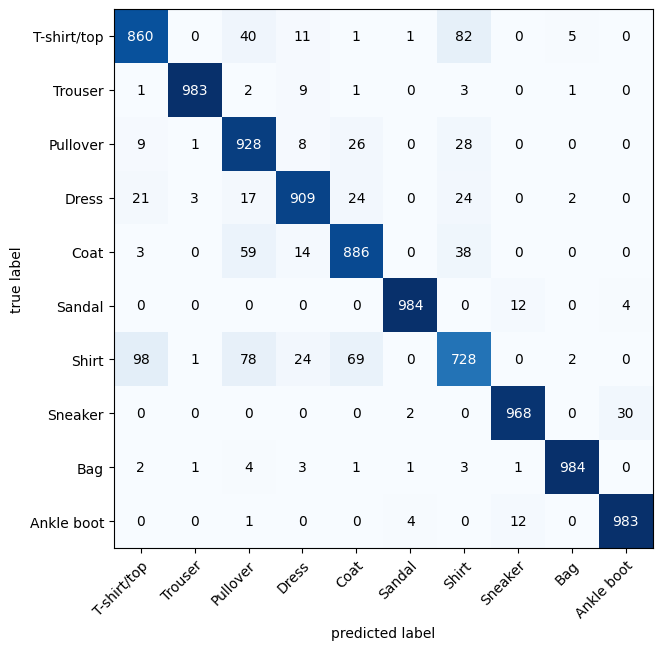

In [166]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [167]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model.pth


In [173]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = FashionMNISTModel(input_shape=1,
                                    hidden_units=32, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

# Evaluate loaded model
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.23556596040725708,
 'model_acc': 92.13258785942492}

In [174]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_results["model_loss"]),
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)